In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#%% Prepare dataset

# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

# Model / data parameters
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1::]

In [3]:
#%% Create model

inputs = tf.keras.Input(shape=input_shape)

def InceptionModule(inputs, f1x1, f3x3, f3x3_reduce, f5x5, f5x5_reduce, fpool):
    conv1_1 = tf.keras.layers.Conv2D(f1x1, kernel_size=(1, 1), padding='same', activation='relu')(inputs)
    
    conv3_1 = tf.keras.layers.Conv2D(f3x3_reduce, kernel_size=(1, 1), padding='same', activation='relu')(inputs)
    conv3_1 = tf.keras.layers.Conv2D(f3x3, kernel_size=(3, 3), padding='same', activation='relu')(conv3_1)
    
    conv5_1 = tf.keras.layers.Conv2D(f5x5_reduce, kernel_size=(1, 1), padding='same', activation='relu')(inputs)
    conv5_1 = tf.keras.layers.Conv2D(f5x5, kernel_size=(5, 5), padding='same', activation='relu')(conv5_1)
    
    pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(inputs)
    pool_1 = tf.keras.layers.Conv2D(fpool, kernel_size=(1, 1), padding='same', activation='relu')(pool_1)

    outputs = tf.keras.layers.Concatenate(axis=-1)([conv1_1, conv3_1, conv5_1, pool_1])
    return outputs


# Initial layers
x = tf.keras.layers.Conv2D(32, (7, 7), padding='same', strides=(1, 1), activation='relu', kernel_initializer=tf.keras.initializers.GlorotUniform())(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same', strides=(1, 1))(x)
x = tf.keras.layers.Conv2D(32, (1, 1), padding='same', strides=(1, 1), activation='relu')(x)
x = tf.keras.layers.Conv2D(96, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((3, 3), padding='same', strides=(1, 1))(x)

# Inception Block 1
x = InceptionModule(
    x,
    f1x1=32,
    f3x3=48,
    f3x3_reduce=64,
    f5x5=8,
    f5x5_reduce=16,
    fpool=16)

x = InceptionModule(
    x,
    f1x1=64,
    f3x3=64,
    f3x3_reduce=96,
    f5x5=16,
    f5x5_reduce=48,
    fpool=32)

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

x = InceptionModule(
    x,
    f1x1=96,
    f3x3=48,
    f3x3_reduce=104,
    f5x5=8,
    f5x5_reduce=24,
    fpool=32)


# Auxillary output 1
x = tf.keras.layers.AveragePooling2D((5, 5), strides=2)(x)
x = tf.keras.layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="inception")
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              # optimizer=optimizer,
              metrics=['accuracy'])

print(model.summary())

Model: "inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   4736        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   1056        max_pooling2d[0][0]              
__________________________________________________________________________________________

In [4]:
#%% Train model

batch_size = 256
epochs = 50

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[earlystop],
                    use_multiprocessing=True,
                    validation_data=(x_test, y_test))

Epoch 1/50
196/196 [==============================] - 62s 263ms/step - loss: 4.2901 - accuracy: 0.0655 - val_loss: 3.7912 - val_accuracy: 0.1292
Epoch 2/50
196/196 [==============================] - 48s 245ms/step - loss: 3.6580 - accuracy: 0.1455 - val_loss: 3.4687 - val_accuracy: 0.1818
Epoch 3/50
196/196 [==============================] - 48s 247ms/step - loss: 3.3823 - accuracy: 0.1927 - val_loss: 3.1948 - val_accuracy: 0.2333
Epoch 4/50
196/196 [==============================] - 49s 249ms/step - loss: 3.1703 - accuracy: 0.2307 - val_loss: 3.0467 - val_accuracy: 0.2614
Epoch 5/50
196/196 [==============================] - 49s 248ms/step - loss: 2.9730 - accuracy: 0.2628 - val_loss: 2.9124 - val_accuracy: 0.2849
Epoch 6/50
196/196 [==============================] - 49s 248ms/step - loss: 2.8271 - accuracy: 0.2920 - val_loss: 2.7619 - val_accuracy: 0.3137
Epoch 7/50
196/196 [==============================] - 49s 248ms/step - loss: 2.6884 - accuracy: 0.3218 - val_loss: 2.7001 - val_ac

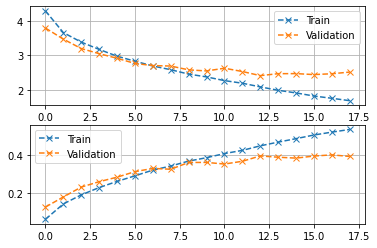

In [5]:
#%% Model visualization
plt.figure()
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(history.history['loss'], '--x')
plt.plot(history.history['val_loss'], '--x')
plt.legend(['Train', 'Validation'])
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(history.history['accuracy'], '--x')
plt.plot(history.history['val_accuracy'], '--x')
plt.legend(['Train', 'Validation'])

In [6]:
#%% Model evaluation
result = model.evaluate(x_test, y_test)
print("Test accuracy: {:.2f}%".format(result[1]*100))

313/313 [==============================] - 4s 11ms/step - loss: 2.4080 - accuracy: 0.3956
Test accuracy: 39.56%
